In [2]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import warnings
from datetime import datetime
import seaborn as sns
import warnings
import datetime
from sklearn.metrics import accuracy_score,confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from collections import Counter
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from collections import Counter
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.mixture import GaussianMixture
warnings.filterwarnings("ignore")
sns.set(font_scale=2.0) 

### Task1: predicting who will submit and who will not submit applications

In [2]:
df = pd.read_excel('./DATA/SLATE.xlsx')
df = df[df['Degree']=='Master\'s']
df = df[df['Time Status']=='Full Time']

In [3]:
# 1: unsubmit, 0: submit based on Dr. Anand's comments
df_new = df.copy()
df_new['submit_status'] = [0]*12686
df_new.loc[df_new['Submitted'].isnull(),'submit_status'] = 1

In [4]:
df_new['submit_status'].value_counts()

0    10129
1     2557
Name: submit_status, dtype: int64

In [5]:
#firstly select possible related columns
df_new = df_new[['Program (ASE)','Have you ever failed a course?',
          'Ever Placed on Academic Probation','Academic Classes Taught in English',
         'Institution 1 Name','Institution 1 GPA (4.0 Scale)','Institution 2 Name','Institution 3 Name',
         'Fellowships Awarded','GRE Verbal Percentile','GRE Quantitative Percentile',
         'GRE Analytical Writing Percentile','Job 1 Organization','Job 2 Organization','Job 3 Organization',
         'Recommender 1 Rating','Recommender 2 Rating','Recommender 3 Rating','Recommender 1 Date/Time',
         'Recommender 2 Date/Time','Recommender 3 Date/Time','Recommender 4 Date/Time','Previously Applied?',
         'How Applicant Heard About UR','Other Schools Applying To','submit_status']]

In [6]:
# have a overview of missing values among unsubmitted tuples
missing = pd.DataFrame(df_new[df_new['submit_status']==1].isnull().sum()).reset_index()
missing.rename(columns={'index':'feature',0:'missing_count'},inplace=True)
missing = missing.sort_values("missing_count")

In [7]:
missing.style.background_gradient()

,feature,missing_count
0,Program (ASE),0
22,Previously Applied?,0
25,submit_status,0
2,Ever Placed on Academic Probation,634
1,Have you ever failed a course?,650
4,Institution 1 Name,1004
3,Academic Classes Taught in English,1019
5,Institution 1 GPA (4.0 Scale),1234
23,How Applicant Heard About UR,1315
8,Fellowships Awarded,1562


Data Preprocessing

In [8]:
df_new['Have you ever failed a course?'] = df_new['Have you ever failed a course?'].fillna(0)
df_new['Ever Placed on Academic Probation'] = df_new['Ever Placed on Academic Probation'].fillna(0)
df_new['Academic Classes Taught in English'] = df_new['Academic Classes Taught in English'].fillna(0)

In [9]:
df_new['Institution 1 GPA (4.0 Scale)'] = df_new['Institution 1 GPA (4.0 Scale)'].fillna(-1)

In [10]:
index = []
nan = list(df_new['Fellowships Awarded'].isnull())
for i in range(len(nan)):
    if nan[i]:
        index.append(i)

In [11]:
award = []
fellowship = list(df_new['Fellowships Awarded'])
for i in range(len(fellowship)):
    if i in index:
        award.append(0)
    elif fellowship[i]=='No':
        award.append(0)
    else:
        award.append(1)
df_new['Fellowships Awarded'] = award

In [12]:
ins1 = list(df_new['Institution 1 Name'].isnull())
ins2 = list(df_new['Institution 2 Name'].isnull())
ins3 = list(df_new['Institution 3 Name'].isnull())

In [13]:
# number of previous educational experience
institution_num = []
for i in range(len(ins1)):
    if ins1[i]:
        institution_num.append(0)
    elif ins2[i]:
        institution_num.append(1)
    elif ins3[i]:
        institution_num.append(2)
    else:
        institution_num.append(3)
df_new['institution_num'] = institution_num

In [14]:
df_new = df_new.drop(["Institution 1 Name",'Institution 2 Name','Institution 3 Name'], axis=1)

In [15]:
df_new['GRE Verbal Percentile'] = df_new['GRE Verbal Percentile'].fillna(-1)
df_new['GRE Quantitative Percentile'] = df_new['GRE Quantitative Percentile'].fillna(-1)
df_new['GRE Analytical Writing Percentile'] = df_new['GRE Analytical Writing Percentile'].fillna(-1)

In [16]:
df_new['Recommender 1 Rating'] = df_new['Recommender 1 Rating'].fillna("missing")
df_new['Recommender 2 Rating'] = df_new['Recommender 2 Rating'].fillna('missing')
df_new['Recommender 3 Rating'] = df_new['Recommender 3 Rating'].fillna("missing")

In [17]:
job1 = list(df_new['Job 1 Organization'].isnull())
job2 = list(df_new['Job 2 Organization'].isnull())
job3 = list(df_new['Job 3 Organization'].isnull())

In [18]:
# number of previous working experiences
job_num = []
for i in range(len(job1)):
    if job1[i]:
        job_num.append(0)
    elif job2[i]:
        job_num.append(1)
    elif job3[i]:
        job_num.append(2)
    else:
        job_num.append(3)
df_new['job_num'] = job_num

In [19]:
df_new = df_new.drop(['Job 1 Organization','Job 2 Organization','Job 3 Organization'], axis=1)

In [20]:
index = []
nan = list(df_new['Previously Applied?'].isnull())
for i in range(len(nan)):
    if nan[i]:
        index.append(i)

In [21]:
new = []
apply = list(df_new['Previously Applied?'])
for i in range(len(apply)):
    if i in index:
        new.append(0)
    elif apply[i]=='No':
        new.append(0)
    else:
        new.append(1)
df_new['Previously Applied?'] = new

In [22]:
ref1 = list(df_new['Recommender 1 Date/Time'].isnull())
ref2 = list(df_new['Recommender 2 Date/Time'].isnull())
ref3 = list(df_new['Recommender 3 Date/Time'].isnull())
ref4 = list(df_new['Recommender 4 Date/Time'].isnull())

In [23]:
# number of submitted reference letters
ref_num = []
for i in range(len(ref1)):
    if ref1[i]:
        ref_num.append(0)
    elif ref2[i]:
        ref_num.append(1)
    elif ref3[i]:
        ref_num.append(2)
    elif ref4[i]:
        ref_num.append(3)
    else:
        ref_num.append(4)
df_new['ref_num'] = ref_num

In [24]:
df_new = df_new.drop(['Recommender 1 Date/Time','Recommender 2 Date/Time',
                'Recommender 3 Date/Time','Recommender 4 Date/Time'], axis=1)

In [25]:
df_new['How Applicant Heard About UR'] = df_new['How Applicant Heard About UR'].fillna("missing")

In [26]:
heard = []
for i in df_new['How Applicant Heard About UR']:
    if i in ['University of Rochester reputation/word of mouth',
             'Read a publication by a faculty member from the University of Rochester',
             'Attended a talk by a faculty member from the University of Rochester','At a discipline-specific conference']:
        heard.append('University of Rochester reputation/word of mouth')
    elif i in ['Referral from someone at my school (mentor/advisor/faculty)',
               'Referral from an affiliate of the University of Rochester']:
        heard.append('referral')
    elif i in ['Internet search','Third-party website']:
        heard.append("internet")
    elif i=='missing' or i=='Family/Friend':
        heard.append(i)
    elif i in ['Recruitment email','Mailing']:
        heard.append('mailing')
    else:
        heard.append('other')
df_new['How Applicant Heard About UR'] = heard

In [27]:
index = []
nan = list(df_new['Other Schools Applying To'].isnull())
for i in range(len(nan)):
    if nan[i]:
        index.append(i)

In [28]:
#number of listed other applied institutions
other_school_num = []
other = list(df_new['Other Schools Applying To'])
for i in range(df_new.shape[0]):
    if i in index:
        other_school_num.append(0)
    else:
        other_school_num.append(len(other[i].split(', ')))
df_new['other_school_num'] = other_school_num

In [29]:
college = list(pd.read_excel("./DATA/school_name.xlsx")['institution'])

In [30]:
def num_of_better_college(x,college):
    x = str(x).split(", ")
    res = 0
    for i in x:
        if i in college:
            res += 1
    return res

In [31]:
# number of applied colleges that have higher rank than UR
num_of_higher_rank = []
for i in df_new['Other Schools Applying To']:
    num_of_higher_rank.append(num_of_better_college(i,college))

In [32]:
df_new['num_of_higher_rank'] = num_of_higher_rank

In [33]:
df_new = df_new.drop("Other Schools Applying To",axis=1)

In [34]:
# convert all categorical variables to dummy (one-hot form) variables
df_new = pd.concat([df_new,pd.get_dummies(df_new['Program (ASE)'])], axis=1)
df_new = pd.concat([df_new,pd.get_dummies(df_new['How Applicant Heard About UR'])], axis=1)
df_new.rename(columns={'missing':'missing(heard)'},inplace=True)
df_new = pd.concat([df_new,pd.get_dummies(df_new['Recommender 1 Rating'])], axis=1)
df_new.rename(columns={'Among the very best':'Among the very best(ref1)','Average':'Average(ref1)',
                   'Top 10%':'Top 10%(ref1)','Top Quarter':'Top Quarter(ref1)','Top 5%':'Top 5%(ref1)',
                  'missing':'missing(ref1)'},inplace=True)
df_new = pd.concat([df_new,pd.get_dummies(df_new['Recommender 2 Rating'])], axis=1)
df_new.rename(columns={'Among the very best':'Among the very best(ref2)','Average':'Average(ref2)',
                   'Top 10%':'Top 10%(ref2)','Top Quarter':'Top Quarter(ref2)','Top 5%':'Top 5%(ref2)',
                  'missing':'missing(ref2)'},inplace=True)
df_new = pd.concat([df_new,pd.get_dummies(df_new['Recommender 3 Rating'])], axis=1)
df_new.rename(columns={'Among the very best':'Among the very best(ref3)','Average':'Average(ref3)',
                   'Top 10%':'Top 10%(ref3)','Top Quarter':'Top Quarter(ref3)','Top 5%':'Top 5%(ref3)',
                  'missing':'missing(ref3)'},inplace=True)

In [35]:
df_new = df_new.drop(["Program (ASE)",'Recommender 1 Rating','Recommender 2 Rating',
              'Recommender 3 Rating','How Applicant Heard About UR'],axis=1)

In [36]:
X = df_new.drop("submit_status",axis=1)
y = df_new['submit_status']

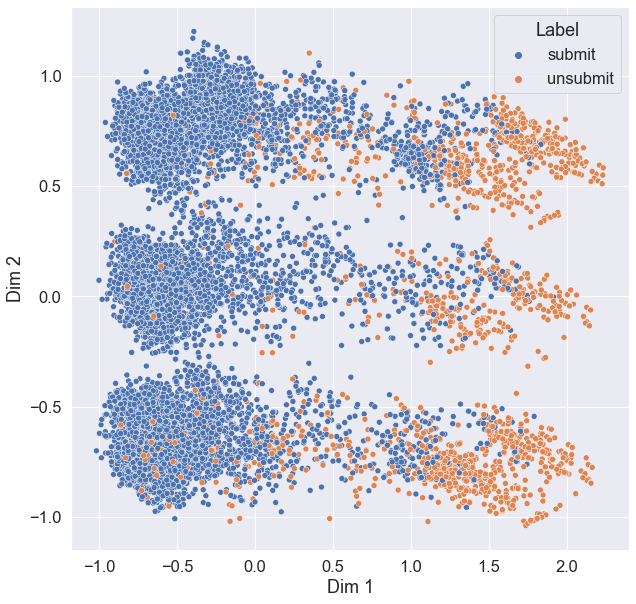

In [129]:
#2-d scatter plot of all data sample
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

X = df_new.drop("submit_status",axis=1)
y = df_new['submit_status']
scaler = MinMaxScaler()
X_new = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_2 = pca.fit_transform(X_new)
data = pd.DataFrame(X_2)
data.columns = ['dim 1','dim 2']
data['label'] = (y.reset_index(inplace=False))['submit_status']
data['label']= data['label'].apply(lambda a : 'unsubmit' if a==1 else "submit")
fig= plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
ax=sns.scatterplot(data=data, x="dim 1", y="dim 2", hue="label")
# ax.set(xlabel='Dim 1', ylabel='Dim 2',font_scale=2)
ax.set_xlabel("Dim 1")
ax.set_ylabel("Dim 2")
#ax.set_title("Scatter Plot of all students in 2 Dimensions")
ax.legend(title ="Label")
plt.savefig('Fig/2dPlot.png', bbox_inches = 'tight')

In [ ]:
# normalize dataset

scaler = MinMaxScaler()
X_new = scaler.fit_transform(X)

In [ ]:
## Gaussian mixture method
gm = GaussianMixture(n_components=2, random_state=0).fit(X_new)

In [ ]:
pred = gm.predict(X_new)

In [ ]:
pred_new = []
for i in pred:
    if i==1:
        pred_new.append(0)
    else:
        pred_new.append(1)

In [ ]:
accuracy_score(pred_new,y)

0.8931105155289295

In [131]:
print(classification_report(pred_new,y))


              precision    recall  f1-score   support

           0       0.90      0.96      0.93      9551
           1       0.85      0.69      0.76      3135

    accuracy                           0.89     12686
   macro avg       0.88      0.83      0.85     12686
weighted avg       0.89      0.89      0.89     12686



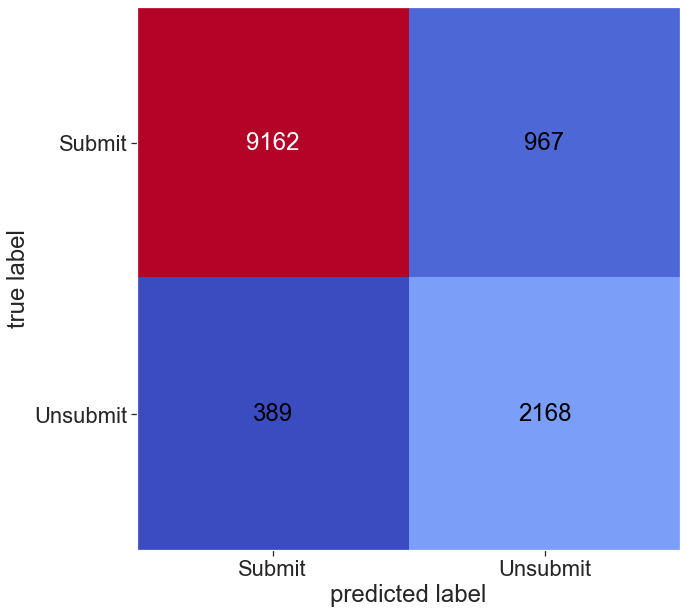

In [132]:
sns.set(font_scale=2.0)
matrix = confusion_matrix(y,pred_new)
figure, ax = plot_confusion_matrix(matrix,cmap='coolwarm',figsize=(10,10))
sns.set(font_scale=2.0) 
ax.set_xticklabels(['', 'Submit', 'Unsubmit'])
ax.set_yticklabels(['', 'Submit', 'Unsubmit'])
plt.savefig("./Fig/GM.png", bbox_inches = 'tight')

In [ ]:
# Logistic regression
# split train and test set

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=265)

clf = LogisticRegression(random_state=265).fit(X_train, y_train)
y_pred = clf.predict(X_test)
clf.score(X_test, y_test)

0.9539007092198581

[Text(0, -1.0, ''),
 Text(0, 0.0, 'Submit'),
 Text(0, 1.0, 'Unsubmit'),
 Text(0, 2.0, '')]

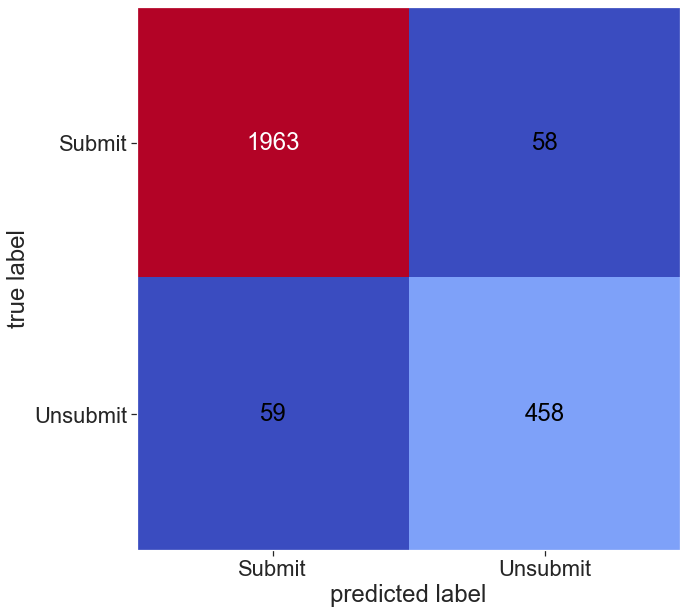

In [ ]:
sns.set(font_scale=2.0)
matrix = confusion_matrix(y_test,y_pred)
figure, ax = plot_confusion_matrix(matrix,cmap='coolwarm',figsize=(10,10))
ax.set_xticklabels(['', 'Submit', 'Unsubmit'])
ax.set_yticklabels(['', 'Submit', 'Unsubmit'])
#plt.savefig("./cm.png")

In [ ]:
# Summary of the predictions made by the classifier

print(classification_report(y_test,y_pred))
print(confusion_matrix(y_pred,y_test))
#Accuracy Score
print('Accuracy is ',accuracy_score(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2021
           1       0.89      0.89      0.89       517

    accuracy                           0.95      2538
   macro avg       0.93      0.93      0.93      2538
weighted avg       0.95      0.95      0.95      2538

[[1963   59]
 [  58  458]]
Accuracy is  0.9539007092198581


In [ ]:
# use SMOTE TOMEK to resampling (solve label imbalance)
kos = SMOTETomek(random_state=42)
X_kos, y_kos = kos.fit_resample(X_train,y_train)
Counter(y_kos)

Counter({1: 8086, 0: 8086})

In [ ]:
# logistic regression + SMOTE TOMEK
clf = LogisticRegression(random_state=265).fit(X_kos, y_kos)
y_pred = clf.predict(X_test)
clf.score(X_test, y_test)

0.9349881796690307

[Text(0, -1.0, ''),
 Text(0, 0.0, 'Submit'),
 Text(0, 1.0, 'Unsubmit'),
 Text(0, 2.0, '')]

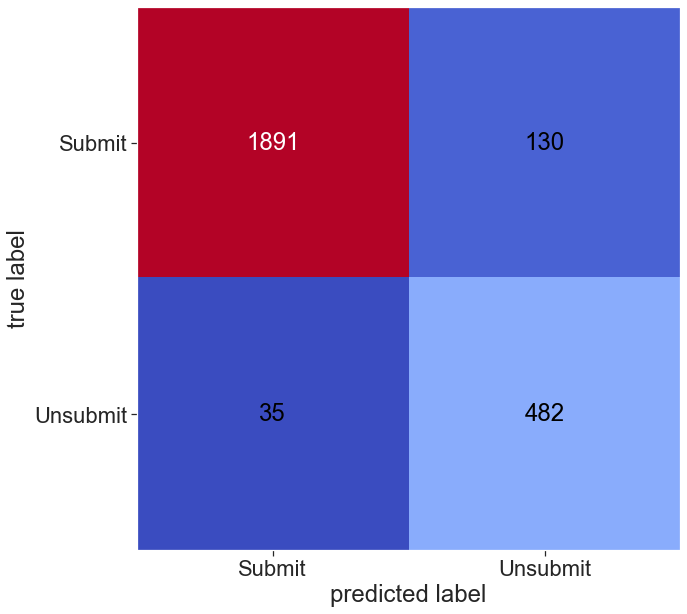

In [ ]:
sns.set(font_scale=2.0)
matrix = confusion_matrix(y_test,y_pred)
figure, ax = plot_confusion_matrix(matrix,cmap='coolwarm',figsize=(10,10))
ax.set_xticklabels(['', 'Submit', 'Unsubmit'])
ax.set_yticklabels(['', 'Submit', 'Unsubmit'])
#plt.savefig("./cm.png")

In [ ]:
# Summary of the predictions made by the classifier

print(classification_report(y_test,y_pred))
print(confusion_matrix(y_pred,y_test))
#Accuracy Score
print('Accuracy is ',accuracy_score(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      2021
           1       0.79      0.93      0.85       517

    accuracy                           0.93      2538
   macro avg       0.88      0.93      0.91      2538
weighted avg       0.94      0.93      0.94      2538

[[1891   35]
 [ 130  482]]
Accuracy is  0.9349881796690307


### Task2: Classification of accept and decline

In [ ]:
# deadline of each entry term for each program
timeline = df.groupby(['Program (ASE)','Entry Term']).agg({'Submitted':'max'})['Submitted'].reset_index()
timeline.rename(columns={'Submitted':'deadline'},inplace=True)

In [ ]:
timeline

,Program (ASE),Entry Term,deadline
0,Computer Science,Fall 2015,2015-05-15 10:53:58
1,Computer Science,Fall 2016,2016-04-29 14:41:09
2,Computer Science,Fall 2017,2017-04-03 11:43:33
3,Computer Science,Fall 2018,2018-04-25 13:57:26
4,Computer Science,Fall 2019,2019-08-08 15:16:47
...,...,...,...
64,Electrical and Computer Engineering,Summer 2018,2018-01-15 00:26:57
65,Electrical and Computer Engineering,Summer 2019,NaT
66,Electrical and Computer Engineering,Summer 2020,2020-06-15 12:23:45
67,Electrical and Computer Engineering,Summer 2021,NaT


In [ ]:
df = df[~df['Decision 1'].isnull()]

In [ ]:
def urdecision(d1):
    if 'Admit' in d1:
        return 'Admit'
    elif 'Withdraw' in d1:
        return ''
    else:
        return 'Reject'

In [ ]:
def applicant_decision(d1,d2,d4):
    if d4=='':
        return 'Withdraw'
    elif d4=='Reject':
        return ''
    else:
        if d1=='Admit/Accept Offer' and d2=='Admit':
            return 'Accept'
        elif d1=='Admit/Defer':
            return 'Defer'
        elif d1=='Admit/Accept/Melt':
            return 'Melt'
        else:
            return 'Decline'

In [ ]:
df['UR_Decision'] = df['Decision 1'].apply(urdecision)
df['Applicant_Decision'] = df.apply(lambda x: applicant_decision(x['Decision 1'],x['Decision 2'],x['UR_Decision'])
                                    ,axis=1)

In [ ]:
df2 = df[(df['UR_Decision']=='Admit')&(df['Applicant_Decision'].isin(['Accept','Decline']))]

In [ ]:
#select some features that reflect applicants' ability and personal preference
df2 = df2[['Program (ASE)','Entry Term','Sex','Age at App Submission','Birth Country','Citizenship1',
           'Academic Classes Taught in English','Institution 1 Location','Institution 1 Name',
           'Institution 1 GPA (4.0 Scale)','Institution 2 Name','Institution 3 Name','GRE Verbal Percentile','GRE Quantitative Percentile',
           'GRE Analytical Writing Percentile','TOEFL Total','IELTS Total','Job 1 Organization',
         'Job 2 Organization','Job 3 Organization','Recommender 1 Date/Time','Recommender 2 Date/Time',
          'Recommender 3 Date/Time','Recommender 4 Date/Time','Previously Applied?','Fellowships Awarded',
           'How Applicant Heard About UR','Other Schools Applying To','Created','Submitted','Applicant_Decision']]

In [ ]:
df2 = pd.merge(df2,timeline,on=['Program (ASE)','Entry Term'])

In [ ]:
df2.isnull().sum()

Program (ASE)                            0
Entry Term                               0
Sex                                      0
Age at App Submission                    0
Birth Country                           16
Citizenship1                             0
Academic Classes Taught in English     502
Institution 1 Location                   9
Institution 1 Name                       0
Institution 1 GPA (4.0 Scale)          201
Institution 2 Name                    2146
Institution 3 Name                    2908
GRE Verbal Percentile                  545
GRE Quantitative Percentile            543
GRE Analytical Writing Percentile      547
TOEFL Total                           1403
IELTS Total                           2912
Job 1 Organization                     819
Job 2 Organization                    1734
Job 3 Organization                    2401
Recommender 1 Date/Time                 68
Recommender 2 Date/Time                 73
Recommender 3 Date/Time                130
Recommender

Start feature engineering

In [ ]:
df2['Academic Classes Taught in English'] = df2['Academic Classes Taught in English'].fillna(0)

In [ ]:
index = []
nan = list(df2['Birth Country'].isnull())
for i in range(len(nan)):
    if nan[i]:
        index.append(i)

In [ ]:
# fill missing values of birth country by citizenship
birth = []
citizen = list(df2['Citizenship1'])
location = list(df2['Birth Country'])
for i in range(len(nan)):
    if i in index:
        birth.append(citizen[i]) 
    else:
        birth.append(location[i])
df2['Birth Country'] = birth

In [ ]:
# categorize citizenship
citizen = []
for i in df2['Citizenship1']:
    if i=='China' or i=='Taiwan':
        citizen.append('China')
    elif i=='United States':
        citizen.append('United States')
    elif i=='India':
        citizen.append('India')
    else:
        citizen.append('other')
df2['Citizenship1'] = citizen

In [ ]:
index = []
nan = list(df2['Institution 1 Location'].isnull())
for i in range(len(nan)):
    if nan[i]:
        index.append(i)

In [ ]:
#fill missing values of institution location by citizenship
loc = []
citizen = list(df2['Citizenship1'])
location = list(df2['Institution 1 Location'])
for i in range(len(nan)):
    if i in index:
        loc.append(citizen[i]+'_ins') 
    elif len(location[i])==2:
        loc.append('United States_ins')
    elif location[i] in ['China','Taiwan']:
        loc.append('China'+'_ins')
    elif location[i]=='India':
        loc.append(location[i]+'_ins')
    else:
        loc.append('other_ins')
df2['Institution 1 Location'] = loc

In [ ]:
Asia = ['Nepal','Iran','Bangladesh','Taiwan','Pakistan','Saudi Arabia','South Korea',
        'Palestine','Kuwait','Philippines','Sri Lanka', 'Vietnam','Indonesia','Azerbaijan',
       'Japan','Armenia','Kazakhstan','Syria','Hong Kong S.A.R.','Singapore','Uzbekistan',
       'Israel','Lebanon','Uzbekistan','Nepal']
Africa = ['Kenya','Rwanda','Egypt','Nigeria','Ghana','Algeria','Ethiopia','Swaziland',
         'Cameroon','Zimbabwe','South Africa','Uganda','Tanzania','Mauritius','Morocco','Burundi']
Europe = ['France','Spain','Turkey','Ukraine','Germany','Albania','Greece','Croatia','Russia',
         'Iceland','Belgium','Denmark','Montenegro','Australia','Romania','Bulgaria','United Kingdom']
SouthAmerica = ['Venezuela','Chile','Argentina','Colombia','Peru','Brazil','Bolivia','Trinidad and Tobago']
NorthAmerica = ['Canada','Haiti','Jamaica','Saint Lucia','Georgia','Panama','Costa Rica',
               'Mexico','Dominican Republic']

In [ ]:
#birth country categorized by continent
continent = []
for i in df2['Birth Country']:
    if i in ['China','India']+Asia:
        continent.append('Asia')
    elif i in Africa:
        continent.append('Africa')
    elif i in Europe:
        continent.append('Europe')
    elif i in SouthAmerica+NorthAmerica+['United States']:
        continent.append('America')
df2['Birth Country'] = continent

In [ ]:
ece_score = np.mean(df2[df2['Program (ASE)']=='Electrical and Computer Engineering']['Institution 1 GPA (4.0 Scale)'])
cs_score = np.mean(df2[df2['Program (ASE)']=='Computer Science']['Institution 1 GPA (4.0 Scale)'])
ds_score = np.mean(df2[df2['Program (ASE)']=='Data Science']['Institution 1 GPA (4.0 Scale)'])

In [ ]:
#fill missing gpa score by average gpa of each program
score = []
program = list(df2['Program (ASE)'])
gpa = list(df2['Institution 1 GPA (4.0 Scale)'])
for i in range(len(gpa)):
    if math.isnan(gpa[i]):
        if program[i]=='Electrical and Computer Engineering':
            score.append(ece_score)
        elif program[i]=='Computer Science':
            score.append(cs_score)
        else:
            score.append(ds_score)
    else:
        score.append(gpa[i])
df2['Institution 1 GPA (4.0 Scale)'] = score

In [ ]:
ins2 = list(df2['Institution 2 Name'].isnull())
ins3 = list(df2['Institution 3 Name'].isnull())

In [ ]:
#number of educational experience
institution_num = []
for i in range(len(ins2)):
    if ins2[i]:
        institution_num.append(1)
    elif ins3[i]:
        institution_num.append(2)
    else:
        institution_num.append(3)
df2['institution_num'] = institution_num

In [ ]:
df2 = df2.drop(["Institution 1 Name",'Institution 2 Name','Institution 3 Name'], axis=1)

In [ ]:
job1 = list(df2['Job 1 Organization'].isnull())
job2 = list(df2['Job 2 Organization'].isnull())
job3 = list(df2['Job 3 Organization'].isnull())

In [ ]:
#number of job experience
job_num = []
for i in range(len(job1)):
    if job1[i]:
        job_num.append(0)
    elif job2[i]:
        job_num.append(1)
    elif job3[i]:
        job_num.append(2)
    else:
        job_num.append(3)
df2['job_num'] = job_num

In [ ]:
df2 = df2.drop(['Job 1 Organization','Job 2 Organization','Job 3 Organization'], axis=1)

In [ ]:
df2['GRE Verbal Percentile'] = df2['GRE Verbal Percentile'].fillna(-1)
df2['GRE Quantitative Percentile'] = df2['GRE Quantitative Percentile'].fillna(-1)
df2['GRE Analytical Writing Percentile'] = df2['GRE Analytical Writing Percentile'].fillna(-1)

In [ ]:
df2.loc[df2['TOEFL Total']==617,'TOEFL Total'] = 105
df2.loc[df2['IELTS Total']>9,'TOEFL Total'] = df2[df2['IELTS Total']>9]['IELTS Total']

In [ ]:
# fill missings of TOEFL by converting IELTS score to TOEFL score of the same level
language = []
toefl = list(df2['TOEFL Total'])
ielts = list(df2['IELTS Total'])
for i in range(df2.shape[0]):
    if not math.isnan(toefl[i]):
        language.append(toefl[i])
    elif not math.isnan(ielts[i]):
        if ielts[i]==8.5:
            language.append(117)
        elif ielts[i]==8:
            language.append(112)
        elif ielts[i]==7.5:
            language.append(105)
        elif ielts[i]==7:
            language.append(98)
        elif ielts[i]==6.5:
            language.append(86)
        elif ielts[i]==6:
            language.append(69)
        elif ielts[i]==5.5:
            language.append(53)
        elif ielts[i]==5:
            language.append(40)
        else:
            language.append(33)
    else:
        language.append(math.nan)

In [ ]:
df2['language'] = language
df2['language'] = df2['language'].fillna(-1)
df2 = df2.drop(["TOEFL Total",'IELTS Total'],axis=1)

In [ ]:
#number of reference before submission
ref_num = []
ref1 = list(df2['Recommender 1 Date/Time'])
ref2 = list(df2['Recommender 2 Date/Time'])
ref3 = list(df2['Recommender 3 Date/Time'])
ref1null = list(df2['Recommender 1 Date/Time'].isnull())
ref2null = list(df2['Recommender 2 Date/Time'].isnull())
ref3null = list(df2['Recommender 3 Date/Time'].isnull())
submit = list(df2['Submitted'])
for i in range(df2.shape[0]):
    if ref1null[i] or ref2null[i] or ref3null[i]:
        l = []
        if not ref1null[i]:
            l.append(ref1[i])
        if not ref2null[i]:
            l.append(ref2[i])
        if not ref3null[i]:
            l.append(ref3[i])
        l = sorted(l)
        if l==[]:
            ref_num.append(0)
        else:
            for j in range(len(l)-1,-2,-1):
                if j==-1:
                    ref_num.append(0)
                    break
                elif l[j]<submit[i]:
                    ref_num.append(j+1)
                    break
    else:
        l = sorted([ref1[i],ref2[i],ref3[i]])
        if l[2]<=submit[i]:
            ref_num.append(3)
        elif l[1]<=submit[i]:
            ref_num.append(2)
        elif l[0]<=submit[i]:
            ref_num.append(1)
        else:
            ref_num.append(0)

In [ ]:
df2['ref_num'] = ref_num
df2 = df2.drop(['Recommender 1 Date/Time','Recommender 2 Date/Time',
                'Recommender 3 Date/Time','Recommender 4 Date/Time'], axis=1)

In [ ]:

enc = OrdinalEncoder()
df2["Previously Applied?"] = enc.fit_transform(np.array(df2["Previously Applied?"]).reshape(-1,1))

In [ ]:
index = []
nan = list(df2['Fellowships Awarded'].isnull())
for i in range(len(nan)):
    if nan[i]:
        index.append(i)

In [ ]:
award = []
fellowship = list(df2['Fellowships Awarded'])
for i in range(len(fellowship)):
    if i in index:
        award.append(0)
    elif fellowship[i]=='Yes':
        award.append(1)
    else:
        award.append(0)
df2['Fellowships Awarded'] = award

In [ ]:
# categorize how applicant heard about UR
heard = []
for i in df2['How Applicant Heard About UR']:
    if i in ['University of Rochester reputation/word of mouth',
             'Read a publication by a faculty member from the University of Rochester',
             'Attended a talk by a faculty member from the University of Rochester','At a discipline-specific conference']:
        heard.append('University of Rochester reputation/word of mouth')
    elif i in ['Referral from someone at my school (mentor/advisor/faculty)',
               'Referral from an affiliate of the University of Rochester']:
        heard.append('referral')
    elif i in ['Internet search','Third-party website']:
        heard.append("internet")
    elif i=='Family/Friend':
        heard.append(i)
    elif i in ['Recruitment email','Mailing']:
        heard.append('mailing')
    else:
        heard.append('other')
df2['How Applicant Heard About UR'] = heard

In [ ]:
index = []
nan = list(df2['Other Schools Applying To'].isnull())
for i in range(len(nan)):
    if nan[i]:
        index.append(i)

In [ ]:
#number of listed other applied school
other_school_num = []
other = list(df2['Other Schools Applying To'])
for i in range(df2.shape[0]):
    if i in index:
        other_school_num.append(0)
    else:
        other_school_num.append(len(other[i].split(', ')))

In [ ]:
df2['other_school_num'] = other_school_num

In [ ]:
school = pd.read_excel("./DATA/school_name.xlsx")
college = list(school['institution'])

In [ ]:
def num_of_better_college(x,college):
    x = str(x).split(", ")
    res = 0
    for i in x:
        if i in college:
            res += 1
    return res

In [ ]:
# number of other applied schools which has higher rank than UR
num_of_higher_rank = []
for i in df2['Other Schools Applying To']:
    num_of_higher_rank.append(num_of_better_college(i,college))
df2['num_of_higher_rank'] = num_of_higher_rank

In [ ]:
def time_to_ddl(time1,time2):
    minutes = int((time2-time1).total_seconds()/60)
    return minutes

In [ ]:
df2['create_to_ddl'] = df2.apply(lambda x:time_to_ddl(x.Created,x.deadline),axis=1) # time length between creating application and deadline
df2['submit_to_ddl'] = df2.apply(lambda x:time_to_ddl(x.Submitted,x.deadline),axis=1) # time length between submission and deadline
df2['Submitted_minute'] = df2.apply(lambda x:time_to_ddl(x.Created,x.Submitted),axis=1) # time spent on application

In [ ]:
df2 = df2.drop(['Entry Term','Other Schools Applying To','Created','Submitted','deadline'],axis=1)

In [ ]:
df2

,Program (ASE),Sex,Age at App Submission,Birth Country,Citizenship1,Academic Classes Taught in English,Institution 1 Location,Institution 1 GPA (4.0 Scale),GRE Verbal Percentile,GRE Quantitative Percentile,...,Applicant_Decision,institution_num,job_num,language,ref_num,other_school_num,num_of_higher_rank,create_to_ddl,submit_to_ddl,Submitted_minute
0,Electrical and Computer Engineering,F,21.0,America,United States,0.0,United States_ins,3.730000,-1.0,-1.0,...,Accept,2,1,-1.0,1,0,0,268971,138054,130917
1,Electrical and Computer Engineering,F,21.0,Asia,China,1.0,United States_ins,3.680000,81.0,95.0,...,Decline,1,3,-1.0,0,0,0,264877,132431,132446
2,Electrical and Computer Engineering,M,23.0,America,United States,0.0,United States_ins,3.700000,-1.0,-1.0,...,Accept,1,1,-1.0,0,0,0,169612,137707,31904
3,Electrical and Computer Engineering,M,21.0,Asia,United States,1.0,United States_ins,3.190000,-1.0,-1.0,...,Decline,1,3,-1.0,2,0,0,183143,130612,52530
4,Electrical and Computer Engineering,F,22.0,America,United States,0.0,United States_ins,3.980000,95.0,97.0,...,Accept,1,0,-1.0,3,0,0,253652,129837,123815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3122,Data Science,M,23.0,Asia,China,1.0,United States_ins,3.500000,-1.0,-1.0,...,Accept,1,1,-1.0,2,1,0,80628,67615,13012
3123,Data Science,F,22.0,Asia,China,1.0,China_ins,3.460000,76.0,96.0,...,Decline,2,3,105.0,3,1,0,363508,363508,0
3124,Data Science,M,23.0,Asia,China,1.0,United States_ins,2.956000,-1.0,-1.0,...,Accept,1,3,-1.0,2,0,0,89431,59536,29895
3125,Data Science,M,23.0,Asia,other,1.0,other_ins,3.432000,-1.0,-1.0,...,Decline,1,3,-1.0,3,0,0,401101,401101,0


In [ ]:
X = df2.drop("Applicant_Decision",axis=1)
y = df2['Applicant_Decision']

In [ ]:
enc = OrdinalEncoder()
X["Program (ASE)"] = enc.fit_transform(np.array(X["Program (ASE)"]).reshape(-1,1))
X["Sex"] = enc.fit_transform(np.array(X["Sex"]).reshape(-1,1))
X["Birth Country"] = enc.fit_transform(np.array(X["Birth Country"]).reshape(-1,1))
X["Citizenship1"] = enc.fit_transform(np.array(X["Citizenship1"]).reshape(-1,1))
X["Institution 1 Location"] = enc.fit_transform(np.array(X["Institution 1 Location"]).reshape(-1,1))
X["How Applicant Heard About UR"] = enc.fit_transform(np.array(X["How Applicant Heard About UR"]).reshape(-1,1))

In [ ]:
# fit random forest model to see feature importance
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(random_state=0)
forest.fit(X, y)

RandomForestClassifier(random_state=0)

In [ ]:
importances = forest.feature_importances_
table = pd.DataFrame()
table['feature'] = list(X.columns)
table['importance'] = importances

In [ ]:
table = table.sort_values(by='importance', ascending=False)

[Text(0.5, 0, 'importance'), Text(0, 0.5, '')]

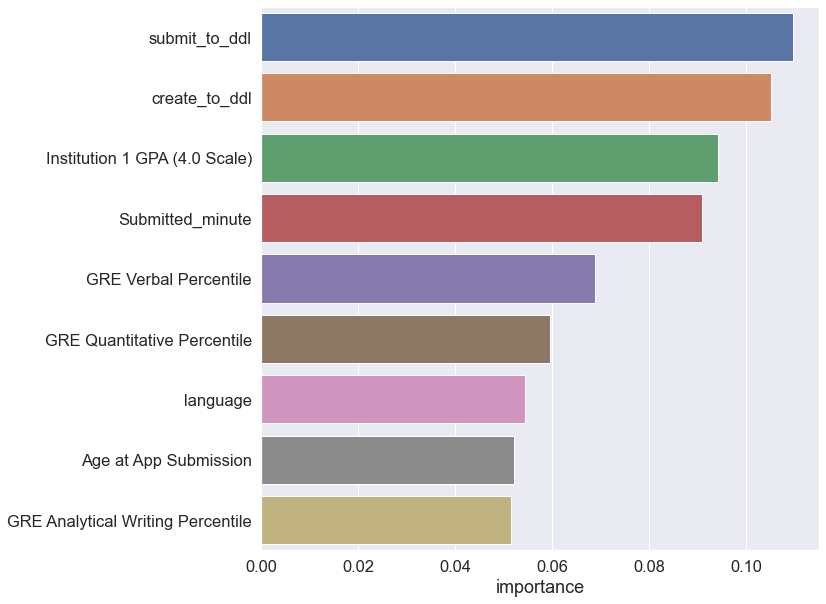

In [ ]:

sns.set(rc={'figure.figsize':(10,10)})
sns.set(font_scale=1.5)
ax = sns.barplot(data = table[0:9],x="importance",y="feature")
ax.set(xlabel='importance', ylabel='')
#plt.savefig("./feature.png")

In [ ]:
# transform categorical variable to dummy variables before training
X1 = pd.concat([df2,pd.get_dummies(df2['Program (ASE)'])], axis=1)
X1 = pd.concat([X1,pd.get_dummies(X1['Sex'])], axis=1)
X1 = pd.concat([X1,pd.get_dummies(X1['Birth Country'])], axis=1)
X1 = pd.concat([X1,pd.get_dummies(X1['Citizenship1'])], axis=1)
X1 = pd.concat([X1,pd.get_dummies(X1['Institution 1 Location'])], axis=1)
X1 = pd.concat([X1,pd.get_dummies(X1['How Applicant Heard About UR'])], axis=1)

In [ ]:
X1

,Program (ASE),Sex,Age at App Submission,Birth Country,Citizenship1,Academic Classes Taught in English,Institution 1 Location,Institution 1 GPA (4.0 Scale),GRE Verbal Percentile,GRE Quantitative Percentile,...,China_ins,India_ins,United States_ins,other_ins,Family/Friend,University of Rochester reputation/word of mouth,internet,mailing,other,referral
0,Electrical and Computer Engineering,F,21.0,America,United States,0.0,United States_ins,3.730000,-1.0,-1.0,...,0,0,1,0,1,0,0,0,0,0
1,Electrical and Computer Engineering,F,21.0,Asia,China,1.0,United States_ins,3.680000,81.0,95.0,...,0,0,1,0,1,0,0,0,0,0
2,Electrical and Computer Engineering,M,23.0,America,United States,0.0,United States_ins,3.700000,-1.0,-1.0,...,0,0,1,0,0,0,0,0,1,0
3,Electrical and Computer Engineering,M,21.0,Asia,United States,1.0,United States_ins,3.190000,-1.0,-1.0,...,0,0,1,0,0,0,0,0,1,0
4,Electrical and Computer Engineering,F,22.0,America,United States,0.0,United States_ins,3.980000,95.0,97.0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3122,Data Science,M,23.0,Asia,China,1.0,United States_ins,3.500000,-1.0,-1.0,...,0,0,1,0,1,0,0,0,0,0
3123,Data Science,F,22.0,Asia,China,1.0,China_ins,3.460000,76.0,96.0,...,1,0,0,0,1,0,0,0,0,0
3124,Data Science,M,23.0,Asia,China,1.0,United States_ins,2.956000,-1.0,-1.0,...,0,0,1,0,0,0,1,0,0,0
3125,Data Science,M,23.0,Asia,other,1.0,other_ins,3.432000,-1.0,-1.0,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
X1 = X1.drop(['Program (ASE)','Sex','Birth Country','Citizenship1','Institution 1 Location','How Applicant Heard About UR','Applicant_Decision'],axis=1)

In [ ]:
# standard normalize
scaler = MinMaxScaler()
X_new = scaler.fit_transform(X1)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2,stratify=y, random_state=42)

In [ ]:
# resampling
kos = SMOTETomek(random_state=42)
X_kos, y_kos = kos.fit_resample(X_train,y_train)
Counter(y_kos)

Counter({'Decline': 1919, 'Accept': 1919})

In [ ]:
model = svm.SVC(kernel='poly',degree=2)
model.fit(X_kos, y_kos)
pred = model.predict(X_test)
matrix = confusion_matrix(y_test,pred)

[Text(0, -1.0, ''),
 Text(0, 0.0, 'Accept'),
 Text(0, 1.0, 'Decline'),
 Text(0, 2.0, '')]

<Figure size 720x720 with 0 Axes>

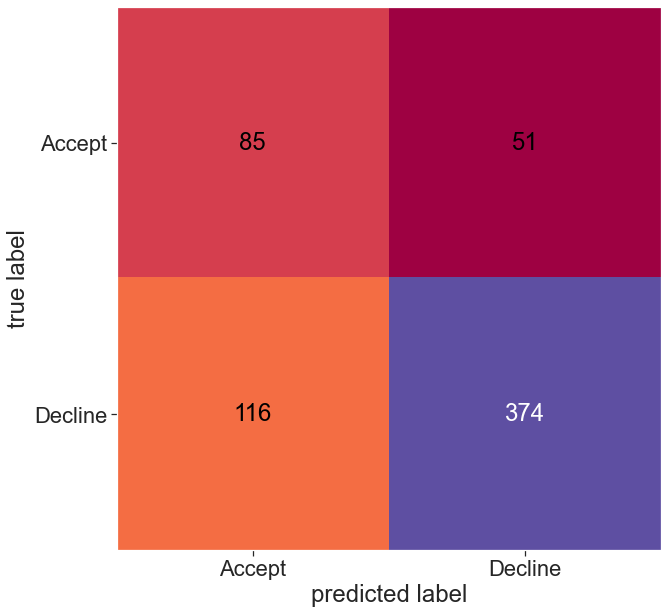

In [ ]:
sns.set(font_scale=2.0)
plt.figure(figsize=(10,10))
figure, ax = plot_confusion_matrix(matrix,cmap='Spectral')
ax.set_xticklabels(['', 'Accept', 'Decline'])
ax.set_yticklabels(['', 'Accept', 'Decline'])
#plt.savefig("./confusion_matrix2.png")

In [ ]:

model = GaussianNB()
model.fit(X_kos, y_kos)

GaussianNB()

[Text(0, -1.0, ''),
 Text(0, 0.0, 'Accept'),
 Text(0, 1.0, 'Decline'),
 Text(0, 2.0, '')]

<Figure size 720x720 with 0 Axes>

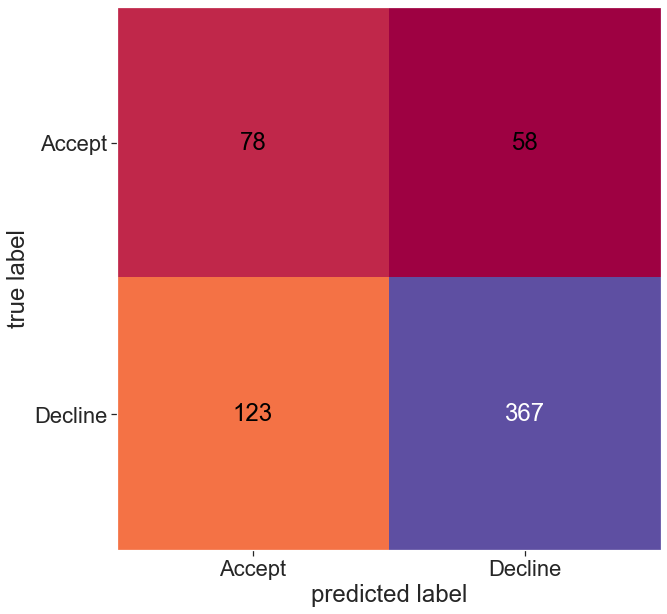

In [ ]:
sns.set(font_scale=2.0)
pred = model.predict(X_test)
plt.figure(figsize=(10,10))
matrix = confusion_matrix(y_test,pred)
figure, ax = plot_confusion_matrix(matrix,cmap='Spectral')
ax.set_xticklabels(['', 'Accept', 'Decline'])
ax.set_yticklabels(['', 'Accept', 'Decline'])
#plt.savefig("./confusion_matrix2.png")

[Text(0, -1.0, ''),
 Text(0, 0.0, 'Accept'),
 Text(0, 1.0, 'Decline'),
 Text(0, 2.0, '')]

<Figure size 720x720 with 0 Axes>

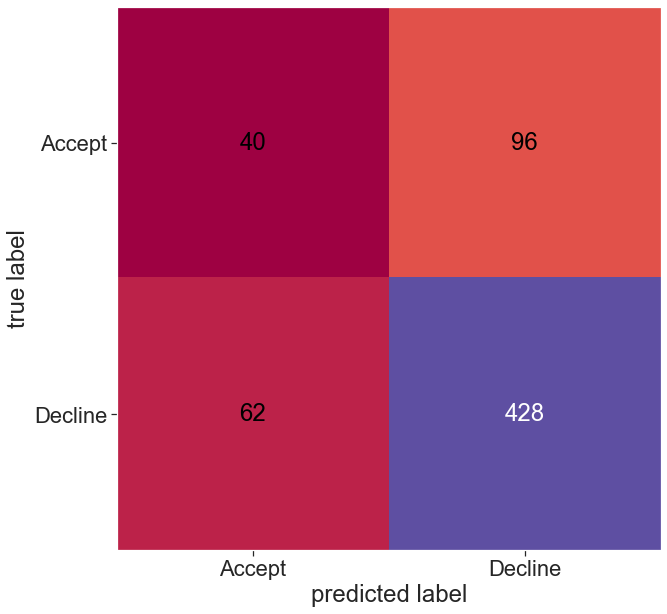

In [ ]:
# rbf kernel
sns.set(font_scale=2.0)
plt.figure(figsize=(10,10))
model = svm.SVC(gamma=2, C=1)
model.fit(X_kos, y_kos)
pred = model.predict(X_test)
matrix = confusion_matrix(y_test,pred)
figure, ax = plot_confusion_matrix(matrix,cmap='Spectral')
ax.set_xticklabels(['', 'Accept', 'Decline'])
ax.set_yticklabels(['', 'Accept', 'Decline'])
#plt.savefig("./confusion_matrix2.png")

[Text(0, -1.0, ''),
 Text(0, 0.0, 'Accept'),
 Text(0, 1.0, 'Decline'),
 Text(0, 2.0, '')]

<Figure size 720x720 with 0 Axes>

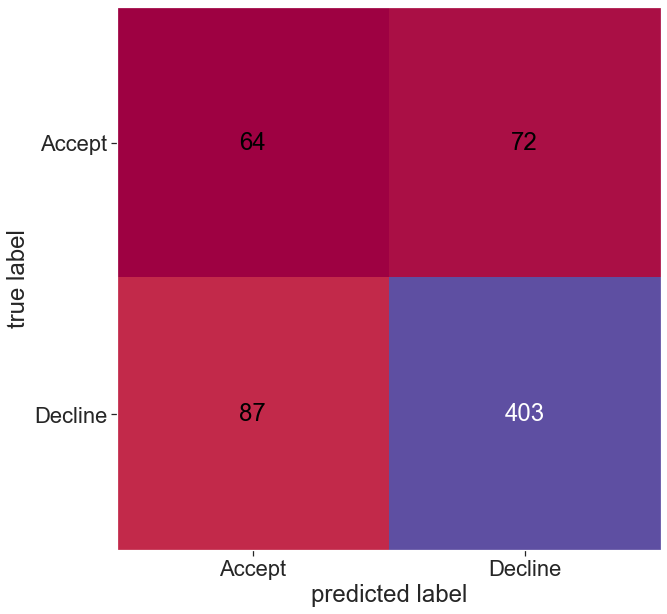

In [ ]:
plt.figure(figsize=(10,10))
model = GaussianProcessClassifier(1.0 * RBF(1.0))
model.fit(X_kos, y_kos)
pred = model.predict(X_test)
matrix = confusion_matrix(y_test,pred)
figure, ax = plot_confusion_matrix(matrix,cmap='Spectral')
ax.set_xticklabels(['', 'Accept', 'Decline'])
ax.set_yticklabels(['', 'Accept', 'Decline'])
#plt.savefig("./confusion_matrix2.png")


<Figure size 720x720 with 0 Axes>

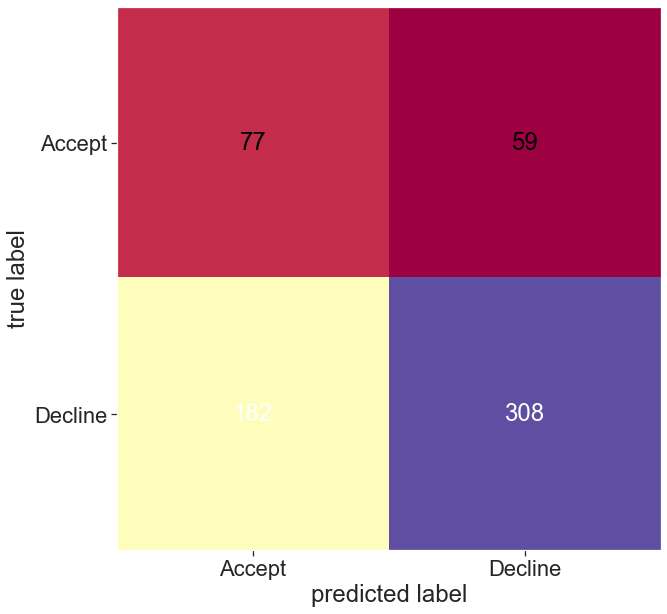

In [ ]:
sns.set(font_scale=2.0) 
plt.figure(figsize=(10,10))
model = KNeighborsClassifier(5)
model.fit(X_kos, y_kos)
pred = model.predict(X_test)
matrix = confusion_matrix(y_test,pred)
figure, ax = plot_confusion_matrix(matrix,cmap='Spectral')
ax.set_xticklabels(['', 'Accept', 'Decline'])
ax.set_yticklabels(['', 'Accept', 'Decline'])
plt.savefig("./confusion_matrix2.png")


<Figure size 720x720 with 0 Axes>

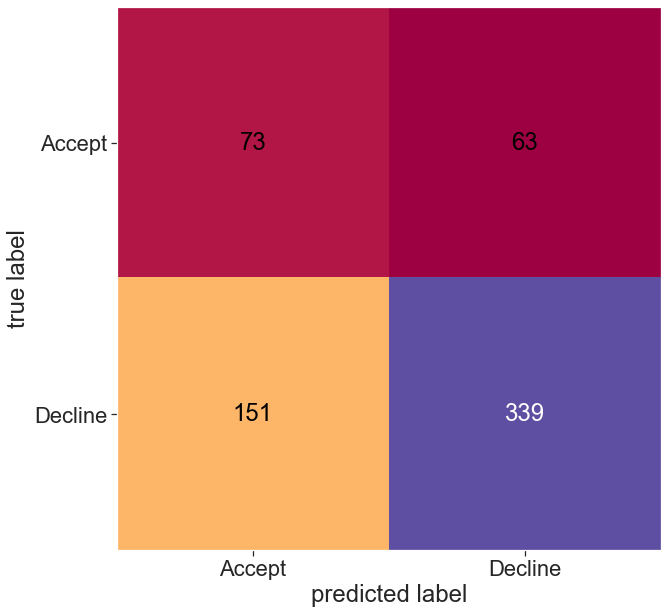

In [ ]:
plt.figure(figsize=(10,10))
model = QuadraticDiscriminantAnalysis()
model.fit(X_kos, y_kos)
pred = model.predict(X_test)
matrix = confusion_matrix(y_test,pred)
figure, ax = plot_confusion_matrix(matrix,cmap='Spectral')
ax.set_xticklabels(['', 'Accept', 'Decline'])
ax.set_yticklabels(['', 'Accept', 'Decline'])
plt.savefig("./confusion_matrix2.png")
